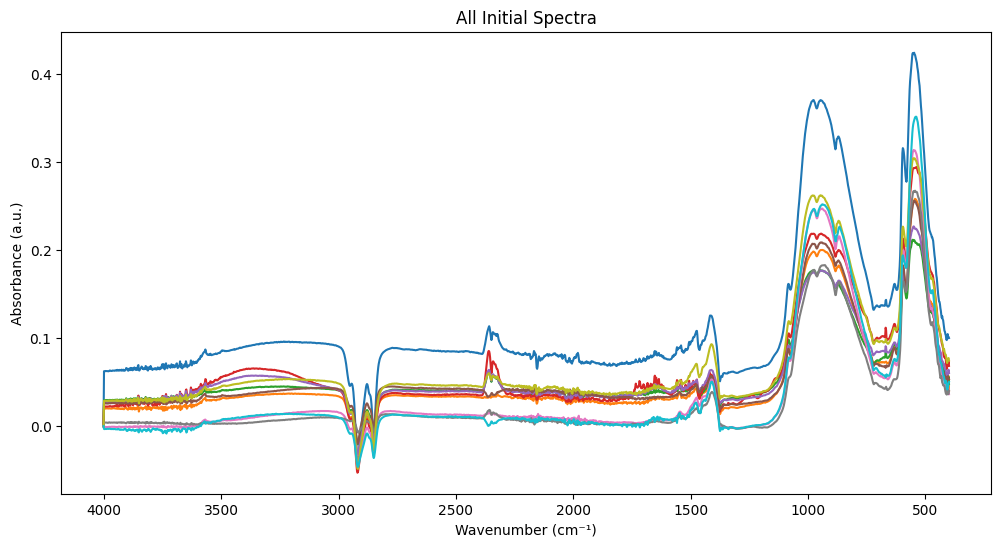


Main Menu:
1 - Spectral Cut
2 - Smoothing (Savitzky-Golay)
3 - Baseline Correction
4 - Normalization
5 - Finish and Save


In [ ]:
!pip install numpy pandas matplotlib scipy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.sparse import csc_matrix, eye, spdiags
from scipy.linalg import cholesky

def baseline_als(y, lam, p, niter=10):
    L = len(y)
    D = csc_matrix(np.diff(np.eye(L), 2))
    w = np.ones(L)
    for i in range(niter):
        W = spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        C = cholesky(Z)
        z = C.solve(W.dot(y))
        w = p * (y > z) + (1 - p) * (y < z)
    return z

def rubberband_correction(y, x):
    # Find points on the baseline
    baseline_points_indices = np.argmin(y, axis=0)
    baseline_points_x = x[baseline_points_indices]
    baseline_points_y = y[baseline_points_indices]

    # Fit a line through the baseline points
    if len(baseline_points_indices) > 1:
        baseline_fit = np.polyfit(baseline_points_x, baseline_points_y, 1)
        baseline = np.polyval(baseline_fit, x)
    else:
        # If only one baseline point, assume a horizontal line
        baseline = np.full_like(x, baseline_points_y[0])

    corrected_spectrum = y - baseline
    return corrected_spectrum

def linear_baseline_correction(y):
    corrected_spectrum = y - y[0] - (y[-1] - y[0]) * (np.arange(len(y)) / (len(y) - 1))
    return corrected_spectrum


def plot_specta(wavenumbers, spectra, title="FTIR Spectra"):
    plt.figure(figsize=(12, 6))
    for i in range(spectra.shape[0]):
        plt.plot(wavenumbers, spectra[i, :])
    plt.xlabel("Wavenumber (cm⁻¹)")
    plt.ylabel("Absorbance (a.u.)")
    plt.title(title)
    plt.gca().invert_xaxis()
    plt.show()

def spectral_cut(wavenumbers, spectra):
    while True:
        try:
            start_wave = float(input("Enter the starting wavenumber for the cut:"))
            end_wave = float(input("Enter the final wavenumber for the cut:"))
            break
        except ValueError:
            print("Invalid input. Please enter a number.")

    cut_indices = np.where((wavenumbers >= end_wave) & (wavenumbers <= start_wave))[0]

    if len(cut_indices) == 0:
        print("No data found in the specified wavenumber range.")
        return wavenumbers, spectra

    cut_wavenumbers = wavenumbers[cut_indices]
    cut_spectra = spectra[:, cut_indices]

    plot_specta(cut_wavenumbers, cut_spectra, title="Cut Spectra")
    return cut_wavenumbers, cut_spectra

def smoothing(wavenumbers, spectra):
    while True:
        try:
            polyorder = int(input("Enter the order of the polynomial for Savitzky-Golay: "))
            window_length = int(input("Enter window size for Savitzky-Golay (odd):"))
            if window_length % 2 == 0:
                print("Window size must be odd.")
                continue
            derivative = int(input("Enter the order of the derivative (0 for smoothing):"))
            if derivative >= window_length:
                 print("The order of the derivative must be smaller than the window size.")
                 continue
            break
        except ValueError:
            print("Invalid input. Please enter an integer.")

    smoothed_spectra = savgol_filter(spectra, window_length=window_length, polyorder=polyorder, deriv=derivative, axis=1)
    plot_specta(wavenumbers, smoothed_spectra, title="Smoothed Spectra")

    while True:
        change_params = input("Do you want to change the smoothing parameters? (s/n): ").lower()
        if change_params in ['s', 'n']:
            break
        else:
            print("Invalid response. Enter 's' for yes or 'n' for no.")
    if change_params == 's':
        return smoothing(wavenumbers, spectra)
    else:
        return smoothed_spectra

def baseline_correction(wavenumbers, spectra):
    while True:
        print("\nBaseline Correction Options:")
        print("A - Rubber Band Correction")
        print("B - Linear Baseline Correction")
        print("C - Asymmetric Least Squares (ALS)")
        choice = input("Choose baseline correction option (A, B, C): ").upper()

        corrected_spectra = np.copy(spectra)

        if choice == 'A':
            for i in range(spectra.shape[0]):
                corrected_spectra[i, :] = rubberband_correction(spectra[i, :], wavenumbers)
            plot_specta(wavenumbers, corrected_spectra, title="Spectra with Rubber Band Correction")
        elif choice == 'B':
             for i in range(spectra.shape[0]):
                corrected_spectra[i, :] = linear_baseline_correction(spectra[i, :])
             plot_specta(wavenumbers, corrected_spectra, title="Spectra with Linear Baseline Correction")
        elif choice == 'C':
            lam = 100  # Parâmetro lambda para ALS (ajustável)
            p = 0.01  # Parâmetro p para ALS (ajustável)
            for i in range(spectra.shape[0]):
                corrected_spectra[i, :] = spectra[i, :] - baseline_als(spectra[i, :], lam, p)
            plot_specta(wavenumbers, corrected_spectra, title="Spectra with ALS Baseline Correction")
        else:
            print("Invalid option. Please choose A, B or C.")
            continue

        while True:
            change_correction = input("Do you want to change the baseline correction? (s/n): ").lower()
            if change_correction in ['s', 'n']:
                break
            else:
                print("Invalid response. Enter 's' for yes or 'n' for no.")
        if change_correction == 'n':
            return corrected_spectra

def normalization(wavenumbers, spectra):
    while True:
        print("\nNormalization Options:")
        print("A - Min-Max Normalization")
        print("B - Standard Normal Variate (SNV)")
        choice = input("Choose normalization option (A, B): ").upper()

        normalized_spectra = np.copy(spectra)

        if choice == 'A':
            min_vals = np.min(spectra, axis=1, keepdims=True)
            max_vals = np.max(spectra, axis=1, keepdims=True)
            normalized_spectra = (spectra - min_vals) / (max_vals - min_vals)
            plot_specta(wavenumbers, normalized_spectra, title="Normalized Spectra (Min-Max)")
        elif choice == 'B':
            mean_vals = np.mean(spectra, axis=1, keepdims=True)
            std_vals = np.std(spectra, axis=1, keepdims=True)
            normalized_spectra = (spectra - mean_vals) / std_vals
            plot_specta(wavenumbers, normalized_spectra, title="Normalized Spectra (SNV)")
        else:
            print("Invalid option. Please choose A or B.")
            continue

        while True:
            change_normalization = input("Do you want to change the normalization? (s/n): ").lower()
            if change_normalization in ['s', 'n']:
                break
            else:
                print("Invalid response. Enter 's' for yes or 'n' for no.")
        if change_normalization == 'n':
            return normalized_spectra


# Carregar o arquivo CSV
try:
    df = pd.read_csv('XA.csv', header=0)
    wavenumbers = df.columns.values.astype(float)
    spectra_data = df.values
except FileNotFoundError:
    print("XA.csv file not found.")
    exit()
except Exception as e:
    print(f"Error reading CSV file: {e}")
    exit()

current_wavenumbers = wavenumbers
current_spectra = spectra_data

# Plotar todos os espectros iniciais
plot_specta(current_wavenumbers, current_spectra, title="All Initial Spectra")

# Menu principal
while True:
    print("\nMain Menu:")
    print("1 - Spectral Cut")
    print("2 - Smoothing (Savitzky-Golay)")
    print("3 - Baseline Correction")
    print("4 - Normalization")
    print("5 - Finish and Save")

    try:
        choice = int(input("Choose an option: "))
    except ValueError:
        print("Invalid input. Please enter a number.")
        continue

    if choice == 1:
        current_wavenumbers, current_spectra = spectral_cut(current_wavenumbers, current_spectra)
    elif choice == 2:
        current_spectra = smoothing(current_wavenumbers, current_spectra)
        # Precisa replotar o gráfico completo após a suavização se não houver corte anterior
        if np.array_equal(current_wavenumbers, wavenumbers):
             plot_specta(current_wavenumbers, current_spectra, title="Smoothed Spectra")
    elif choice == 3:
        current_spectra = baseline_correction(current_wavenumbers, current_spectra)
        # Precisa replotar o gráfico completo após a correção se não houver corte anterior
        if np.array_equal(current_wavenumbers, wavenumbers):
            plot_specta(current_wavenumbers, current_spectra, title="Baseline-Corrected Spectra")
    elif choice == 4:
        current_spectra = normalization(current_wavenumbers, current_spectra)
         # Precisa replotar o gráfico completo após a normalização se não houver corte anterior
        if np.array_equal(current_wavenumbers, wavenumbers):
            plot_specta(current_wavenumbers, current_spectra, title="Normalized Spectra")
    elif choice == 5:
        print("\nFinal result of preprocessed spectra:")
        plot_specta(current_wavenumbers, current_spectra, title="Finalized Spectra")

        while True:
            change_final = input("Do you want to make any other changes? (s/n): ").lower()
            if change_final in ['s', 'n']:
                break
            else:
                print("Invalid response. Enter 's' for yes or 'n' for no.")

        if change_final == 'n':
            output_df = pd.DataFrame(current_spectra, columns=current_wavenumbers)
            output_filename = 'XA_preprocessado.csv'
            output_df.to_csv(output_filename, index=False)
            print(f"\nEspectros preprocessados salvos em '{output_filename}'")
            break
        else:
            continue # Retorna ao menu principal
    else:
        print("Invalid option. Please choose an option from 1 to 5.")